# CNN classification

The process of building a convolutional neural network for image classification is described here.

In [2]:
import pickle

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

from IPython.display import clear_output
from tqdm import tqdm
import pickle

## Data

For this notebook, `CIFAR10` is used. So it's loaded in the following cell.

In [3]:
train_dataset = CIFAR10(
    './cifar10', 
    train=True, 
    transform=T.ToTensor(),
    download = True
)
valid_dataset = CIFAR10(
    './cifar10', 
    train=False,
    transform=T.ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


So here is some pictures each belongs to some class. Below is visualisation that contains random picutres from sample with it classes in title.

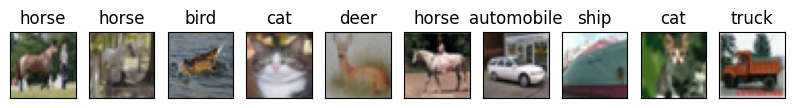

In [4]:
np.random.seed(15)
indx = np.random.choice(np.arange(len(train_dataset)), 10)
t = [train_dataset[i] for i in indx]

cifar10_classes = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

plt.figure(figsize = (10, 5))
for i in range(len(indx)):

    plt.subplot(1, len(indx), i + 1)
    plt.title(cifar10_classes[t[i][1]])
    plt.imshow(T.ToPILImage()(t[i][0]))
    plt.xticks([]);plt.yticks([])

There are some tricks at the data level:

- Both training and validation data need to be better normalised;
- For the training data, we added some augmentations that usually make the model more robust.

In [5]:
means = (train_dataset.data / 255).mean(axis=(0, 1, 2))
stds = (train_dataset.data / 255).std(axis=(0, 1, 2))

train_transforms = T.Compose(
    [
        T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

train_dataset = CIFAR10(
    './cifar10', 
    train=True, 
    transform=train_transforms,
    download = True
)
valid_dataset = CIFAR10(
    './cifar10', 
    train=False,
    transform=test_transforms,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


## Architecture

This is a very simple, but somewhat bulky architecture. There is a convolutional block which contains several convolutional transformations. After each convolutional transformation in the block there is normalisation and ReLU. Each block is finished with MaxPooling that reduces input dimensions twice and Dropout that regularises the model. In the model we repeat such block several times and finally fully connected layers generate final prediction.

In [44]:
class ScipConConv2d(nn.Conv2d):
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return super().forward(input) + input

def get_conv_block(in_channels, out_channels, conv_convertions):
    res = []
    
    for i in range(conv_convertions):
        res += [
            (
                nn.Conv2d(
                    in_channels=in_channels, 
                    out_channels=out_channels, 
                    kernel_size=3, 
                    padding=1
                )
                if i == 0 else            
                ScipConConv2d(
                    in_channels=out_channels, 
                    out_channels=out_channels, 
                    kernel_size=3, 
                    padding=1
                )
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]
    res.append(nn.MaxPool2d(2))
    res.append(nn.Dropout2d(p=0.15))

    return res


class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnov_blocks = [

        ]
        
        self.net = nn.Sequential(
            *get_conv_block(3, 32, 4),
            *get_conv_block(32, 64, 4),
            *get_conv_block(64, 128, 4),
            
            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

## Fitting

Here is everything we needed to make the model fit. Everything is quite simple except learning the scheduler. It's a tool that allows to reduce the steps of the optimiser to get better optimisation results.

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma = 0.5)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=256, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

def train(model) -> tuple[float, float]:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(15, 18))

    plt.subplot(211)
    plt.title(title + ' loss')
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()


    plt.subplot(212)
    plt.title(title + ' accuracy')
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

This model fitting requires a noticeable amount of computation, but we have calculated everything and saved the results, the Wednesday cell just represents the code used for training.

```python
history = {
    "train_loss" : [],
    "valid_loss" : [],
    "train_accuracy" : [],
    "valid_accuracy" : []
}
```

```python
for epoch in range(1):
    train_loss, train_accuracy = train(model)
    valid_loss, valid_accuracy = evaluate(model, valid_loader)

    history["train_loss"].append(train_loss)
    history["valid_loss"].append(valid_loss)

    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)

    clear_output()

    plot_stats(
        history["train_loss"], history["valid_loss"],
        history["train_accuracy"], history["valid_accuracy"],
        "Learning curves"
    )
    plt.show()

    scheduler.step()
```

```python
torch.save(model.state_dict(), open("cnn_classification_files/mod.pck", "wb"))
pickle.dump(history, open("cnn_classification_files/fit_history.pck", "wb"))
```

Here is plotted learning curves for model. As you can see the final accuracy is 88%.

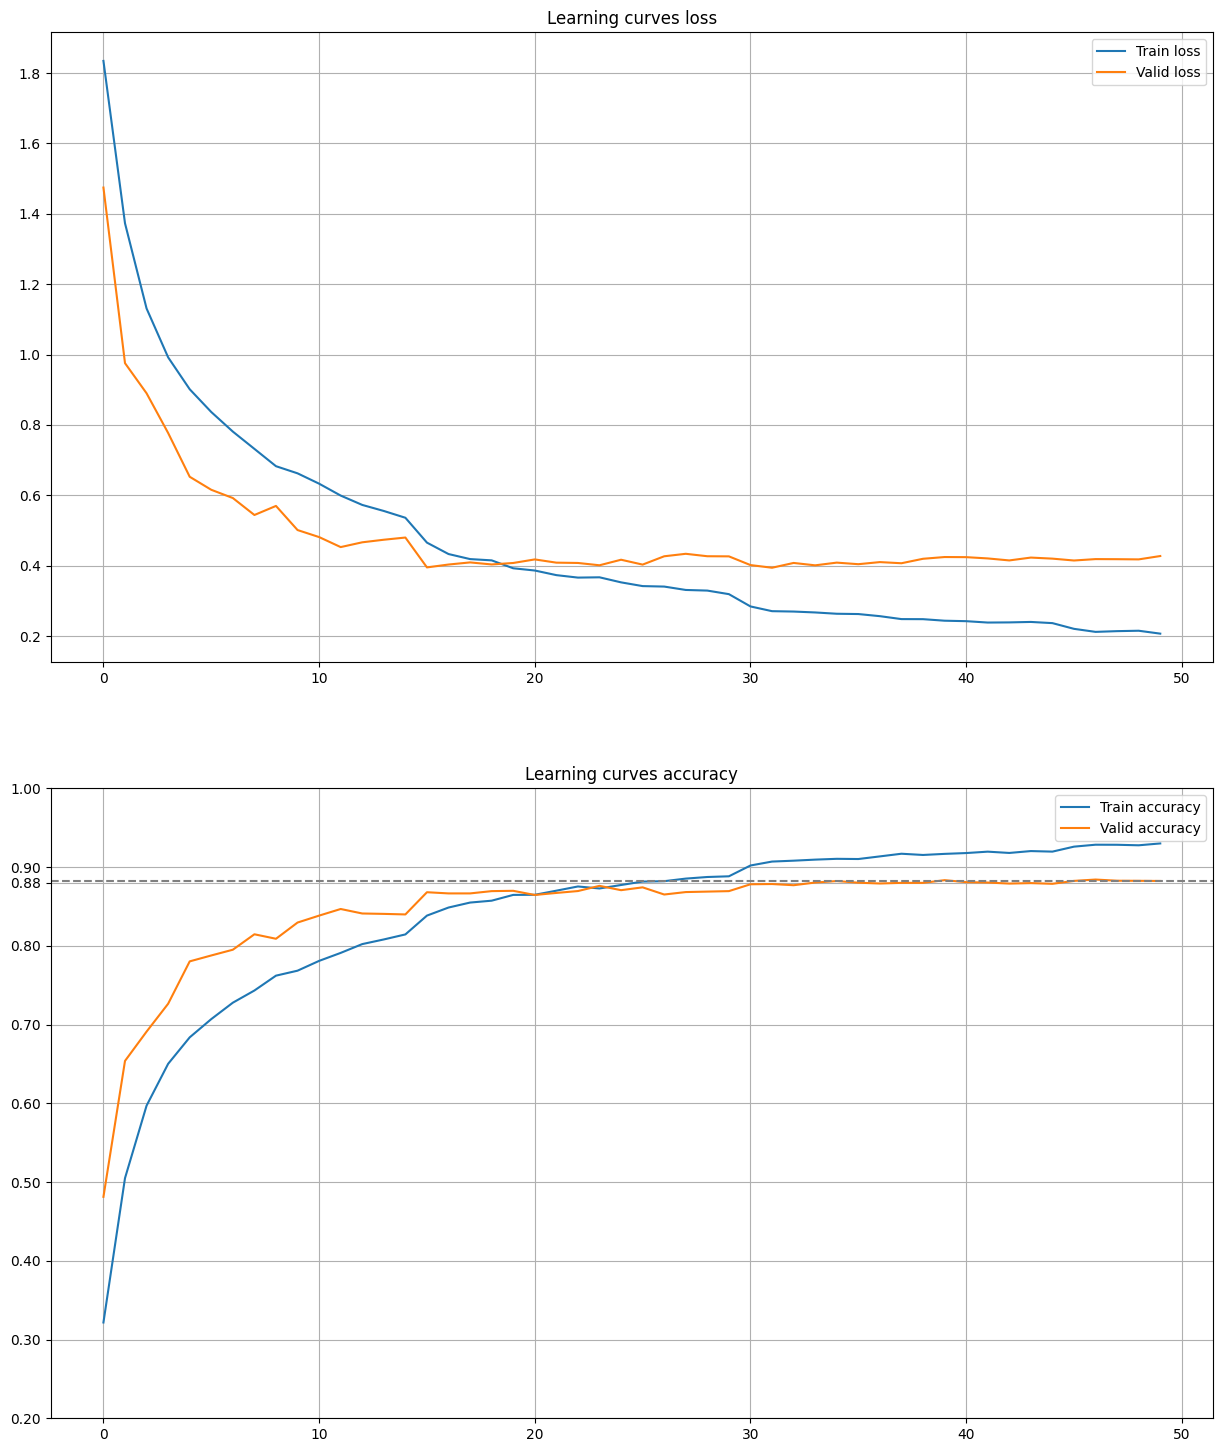

In [7]:
history = pickle.load(open("cnn_classification_files/fit_history.pck", "rb"))

plot_stats(
    history["train_loss"], history["valid_loss"],
    history["train_accuracy"], history["valid_accuracy"],
    "Learning curves"
)

final_accuracy = history["valid_accuracy"][-1]
plt.axhline(final_accuracy, color="gray", linestyle="--")

plt.yticks(list(plt.yticks()[0]) + [round(final_accuracy, 2)])
plt.show()

## Playing with model

Let's check models accruraby but not with strickt metric, but with our eyes. Sometimes it's ever for numan hard to understand what exactly displayed on 32x32 piture. So let's see what model thinks but not strict classes, but the ratio of model certainties in different classes.

Here is fitted model so you can just download it and do what ever you want.

Files already downloaded and verified


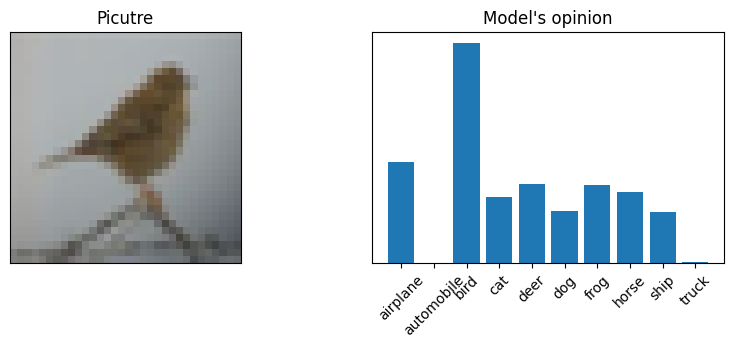

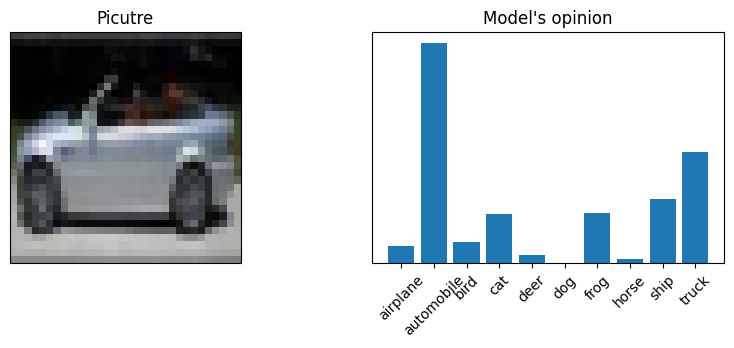

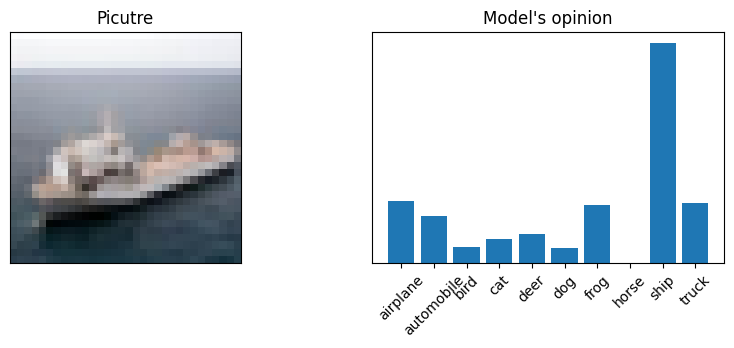

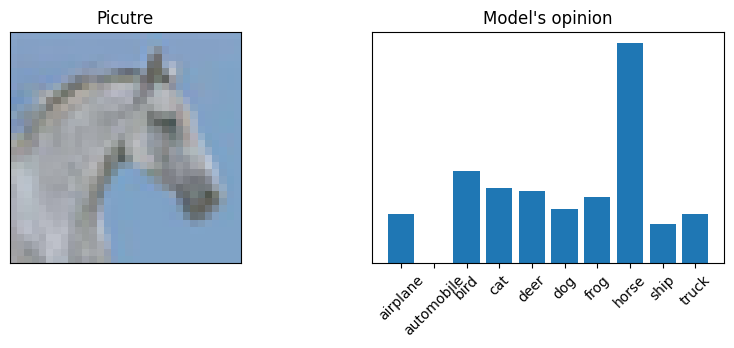

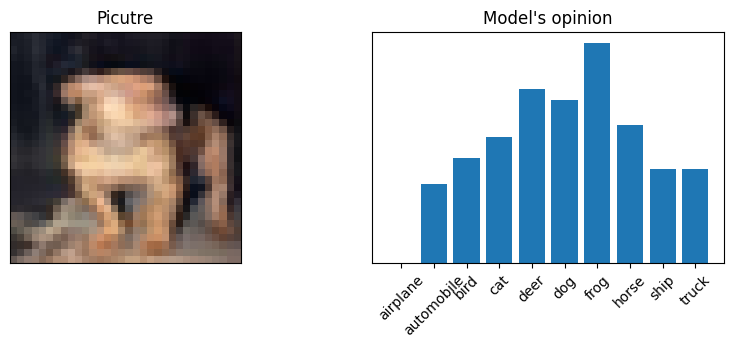

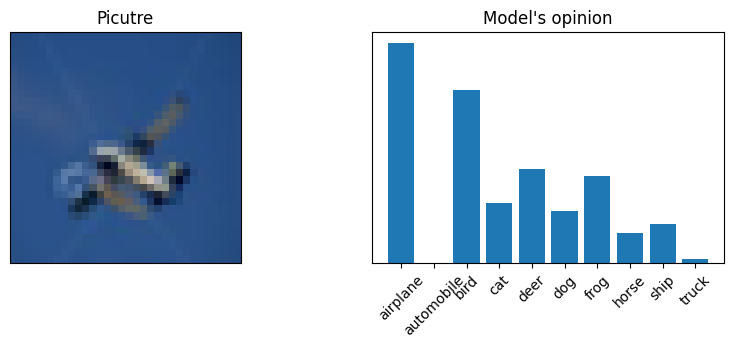

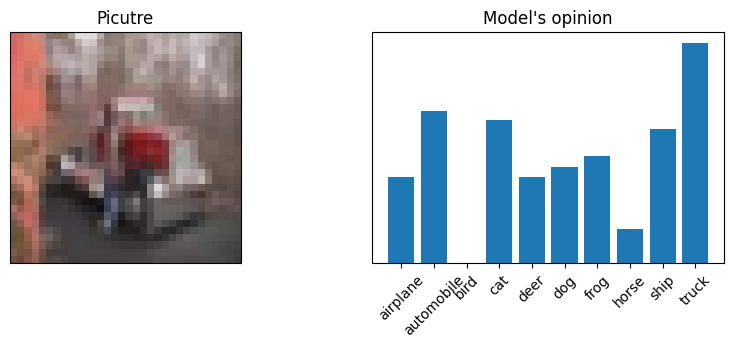

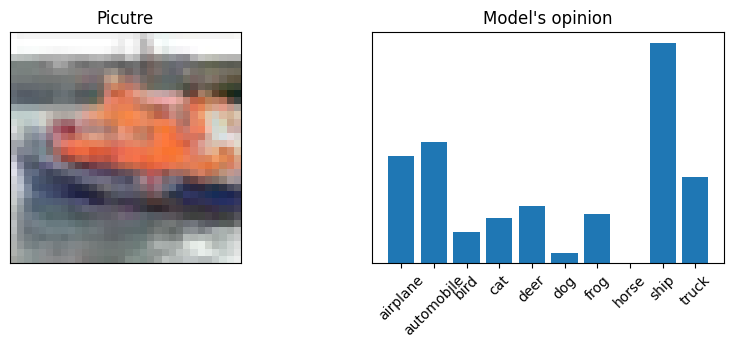

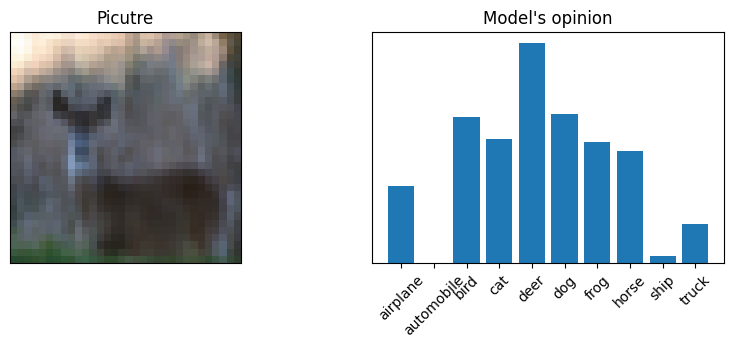

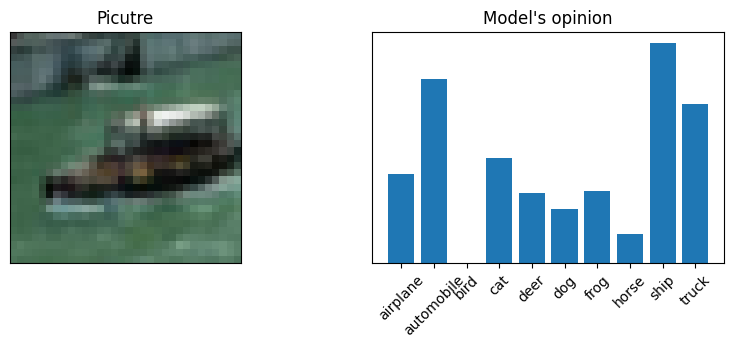

In [74]:
model = Model()

with open("cnn_classification_files/mod.pck", "rb") as f:
    model.load_state_dict(torch.load(f, map_location=torch.device('cpu')))

model = model.eval()

no_transform_valid = CIFAR10(
    './cifar10', 
    train=False,
    download=True
)

indx = np.random.choice(np.arange(len(no_transform_valid)), 10)
predicts = model(
    torch.stack(
        [train_transforms(no_transform_valid[i][0]) for i in indx]
    )
)

predicts

for n, i in enumerate(indx):
    plt.figure(figsize = (10, 3))
    
    plt.subplot(121)
    plt.title("Picutre")
    plt.imshow(no_transform_valid[i][0])
    plt.xticks([]); plt.yticks([])
    
    plt.subplot(122)
    plt.title("Model's opinion")
    plt.bar(
        cifar10_classes.values(), 
        (predicts[n] + predicts[n].min().abs()).detach().numpy()
    )
    plt.xticks(rotation = 45);plt.yticks([])
    plt.show()